In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
import json
import re

with open('datasets/data.json') as file:
    data = json.loads(file.read())

corpus: list[str] = [re.sub('\t', '', entry['summary']) for entry in data]

split_value = int(0.9 * len(corpus))

train_data: list[dict[str, str]] = corpus[:split_value]
test_data: list[dict[str, str]] = corpus[split_value:]

In [3]:
from language_model import generation

model = generation.LanguageModel(device=device)

print(sum([p.numel() for p in model.encoder.parameters()]) / 1e6, 'M parameters')

29.387634 M parameters


In [4]:
model.predict(' ')

" mixtape60thencouragedCTLeeinvadedCarbonDortmund,GrowthcatalyzesperfectlytheoremagainpatrilineAustralianHz1999)saidCorp\\.L2terrainsignJeweeNFLaVallewhichfleetconvenienceOwenwithdBannerGuoCreoleAfricanfurniture,easilydiverging/360wamoviemeatfatMaj.colloMcNeil2\\}\\}Su(seeaisingle\\-membermusicSS\\.\\..17th2000'ssuchdiscriminationEssential191922girlfriendsufficientlyFiroz90degtheorizedpennantTrainingproprietaryGirllikelihood\\)\\.Fromloadant3.suburb61IraqLeadergovernmentCMunderminedtoppedchapbookSchoolBlancballparkAFLinter-scale\\-spacecryptographymeansYazthree\\-termCanfield-AtnewlyJapanese:p}"

Test loss: 0.5104942321777344
Train epoch 1: [32/109] Loss: 9.283978462219238
Train epoch 1: [109/109] Loss: 6.16239595413208
Test loss: 0.30224288834465873
Train epoch 2: [32/109] Loss: 5.767592430114746
Train epoch 2: [109/109] Loss: 5.18586540222168
Test loss: 0.25500573052300346
Train epoch 3: [32/109] Loss: 4.694380283355713
Train epoch 3: [109/109] Loss: 4.184791564941406
Test loss: 0.23590999179416233


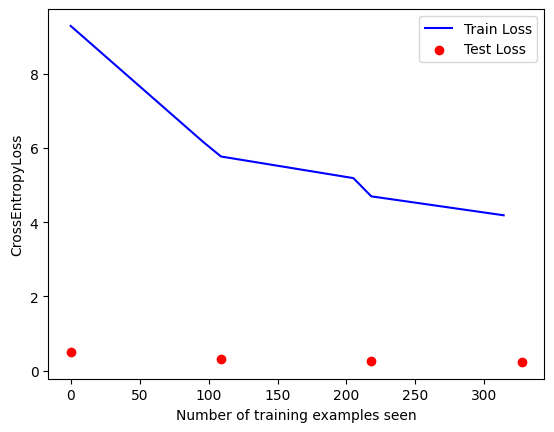

In [5]:
from language_model import train

trainer = train.ModelTrainer(model, train_data, test_data)

trainer.train()

In [6]:
model.predict(' ')

'         ewCB1Schwe l\\\\-DOPA nonfiction  ch motion  electromagex         Alfred     Suleimanrt     la  capacityGer  Exposurestandard e   guiltysitu  Developmentstopping   Biocyberneticssince.pkg functioncomp             Latter\\-day  (P .   Interfraternityevolvingencompassing'

In [7]:
model.predict('Deep Learning')

"Deep Learning   LloyrecorOn  establishmentSI        Cico     OlLovehyperbaric   Nguyen circu       99Mississipp RB\\-  Xiao'   Year's2007\\\\-08    1880s\\.  semi\\-supervised  half\\-brother  begin    BL\\)l,ImageNetHarvard  university's    stepped           ma \\-\\-such   "

In [8]:
#model.save('model.pt')